<a href="https://colab.research.google.com/github/Hrishikesh16nikam/AES-RES-Kyber/blob/main/Machine_Learning_SVM_MLP_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training set: 2000 samples
Test set: 20000 samples


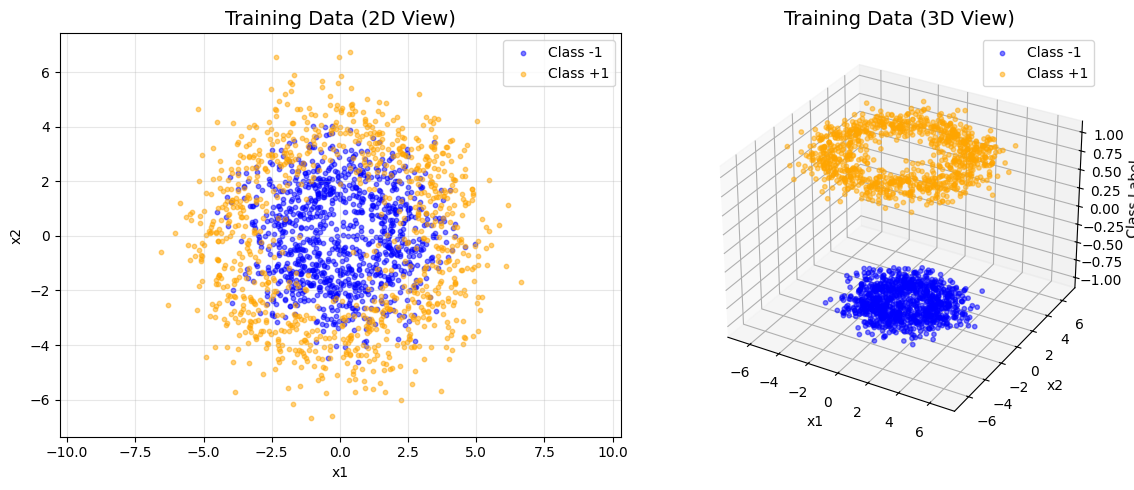


SVM HYPERPARAMETER SEARCH (10-FOLD CROSS-VALIDATION)
Fitting 10 folds for each of 16 candidates, totalling 160 fits

Best parameters for SVM: {'C': 10, 'gamma': 0.1}
Best cross-validation accuracy for SVM: 83.15%


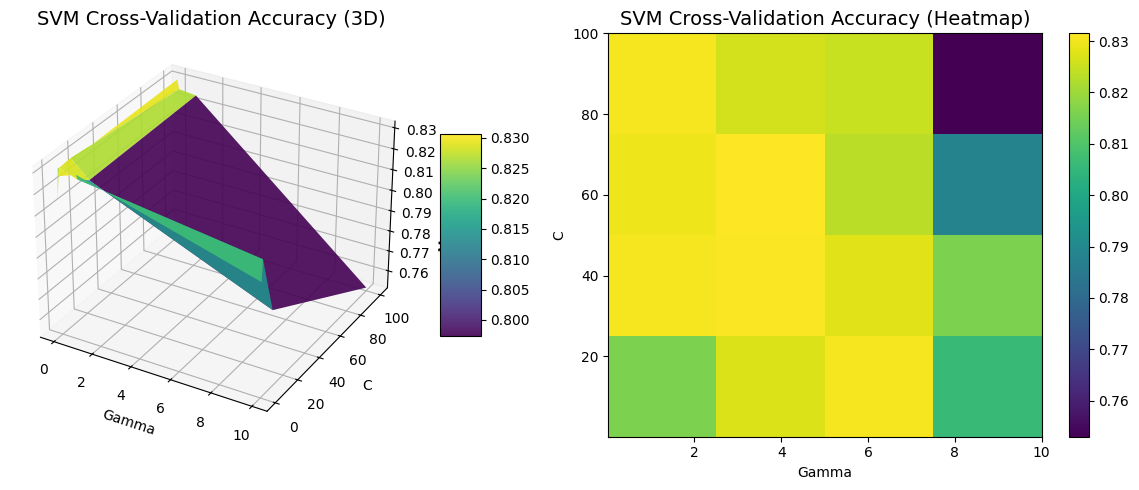


Test accuracy for SVM: 83.31%
Estimated probability of error for SVM: 16.69%

MLP HYPERPARAMETER SEARCH (10-FOLD CROSS-VALIDATION)
Fitting 10 folds for each of 5 candidates, totalling 50 fits

Best parameters for MLP: {'hidden_layer_sizes': (50,)}
Best cross-validation accuracy for MLP: 83.95%


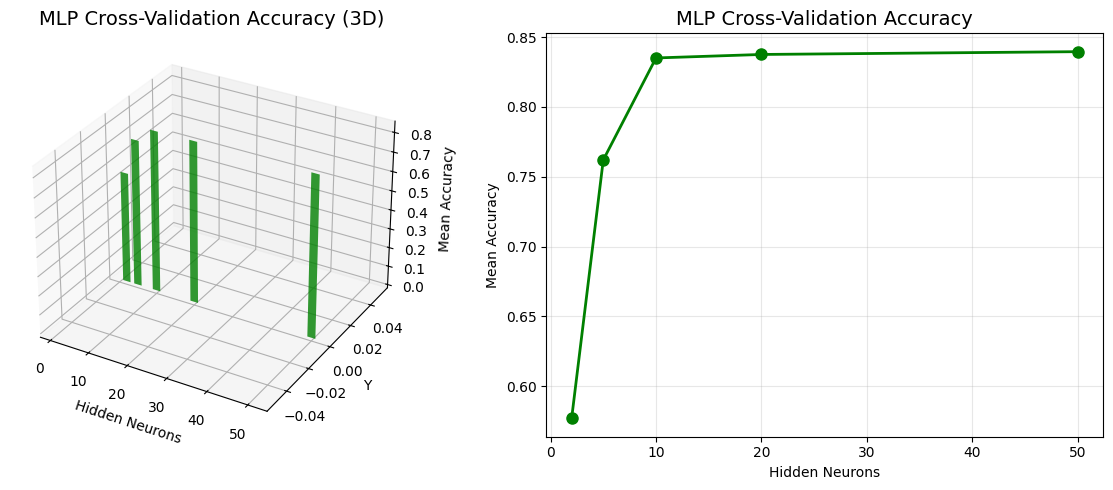


Test accuracy for MLP: 83.34%
Estimated probability of error for MLP: 16.65%


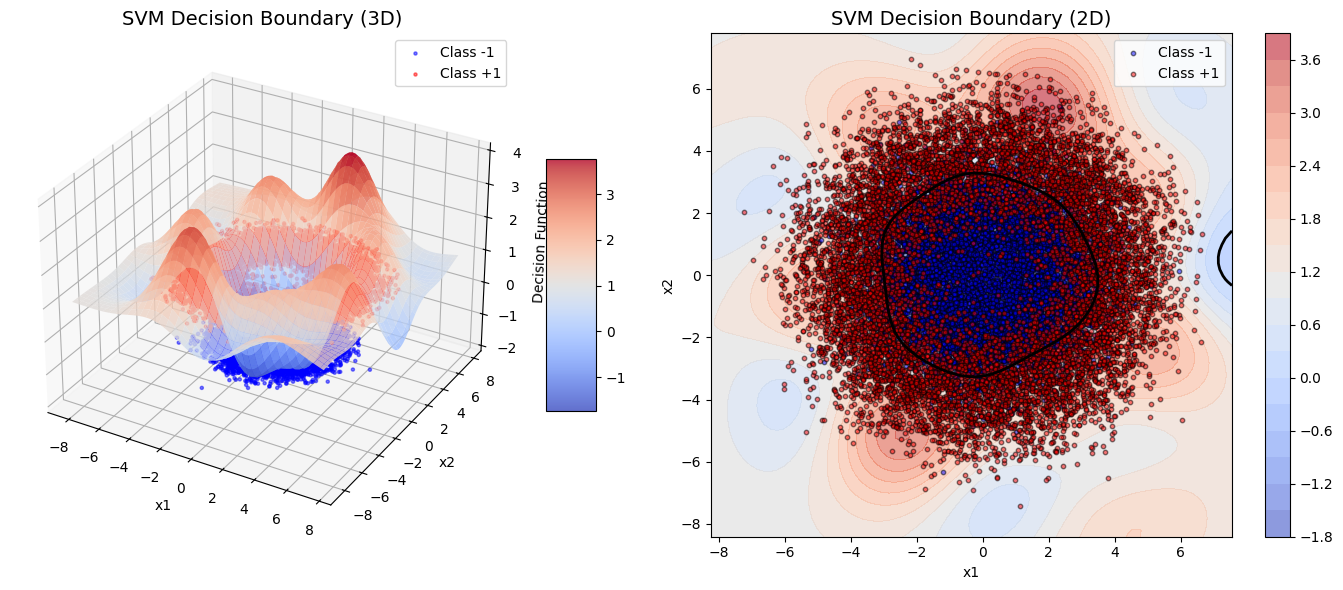

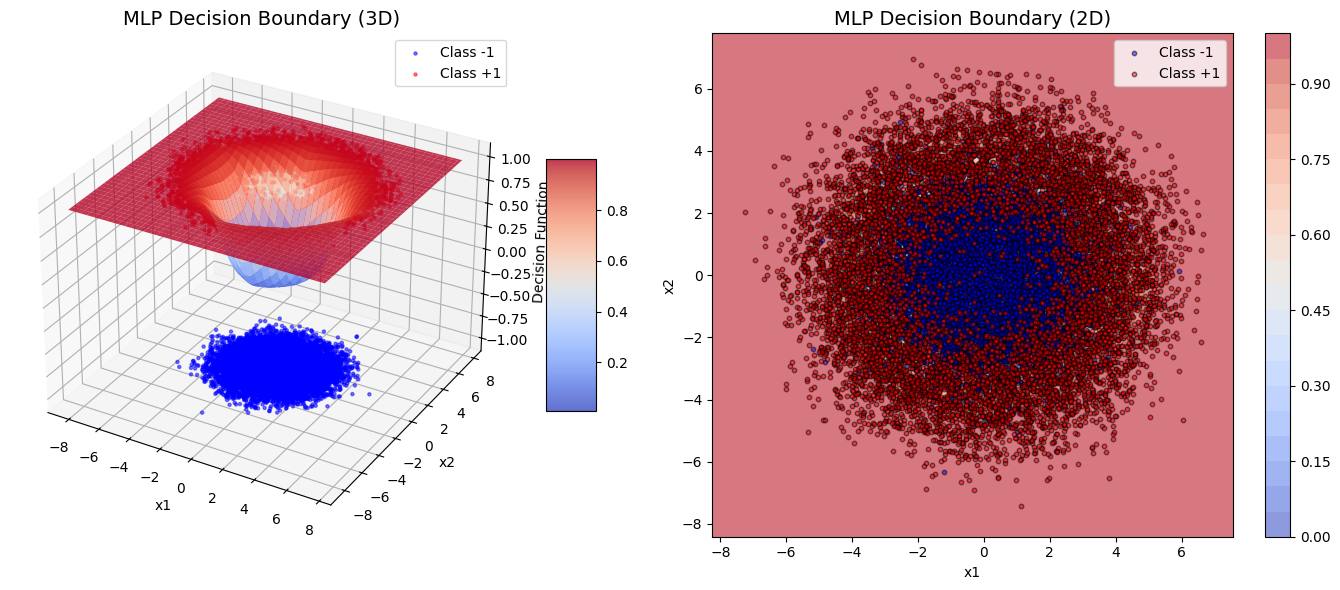

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

# Set random seed
np.random.seed(42)

# ============================================================================
# DATA GENERATION
# ============================================================================

def generate_data(r, n_samples):
    """Generate data from concentric circles with Gaussian noise"""
    theta = np.random.uniform(-np.pi, np.pi, n_samples)
    x = r * np.vstack((np.cos(theta), np.sin(theta)))
    noise = np.random.normal(0, 1, x.shape)
    return (x + noise).T

# Generate training data (1000 samples per class)
n_train = 1000
X_train_neg = generate_data(2, n_train)
X_train_pos = generate_data(4, n_train)
y_train_neg = -np.ones(n_train)
y_train_pos = np.ones(n_train)

X_train = np.vstack((X_train_neg, X_train_pos))
y_train = np.hstack((y_train_neg, y_train_pos))

# Generate test data (10000 samples per class)
n_test = 10000
X_test_neg = generate_data(2, n_test)
X_test_pos = generate_data(4, n_test)
y_test_neg = -np.ones(n_test)
y_test_pos = np.ones(n_test)

X_test = np.vstack((X_test_neg, X_test_pos))
y_test = np.hstack((y_test_neg, y_test_pos))

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ============================================================================
# VISUALIZE TRAINING DATA
# ============================================================================

fig = plt.figure(figsize=(12, 5))

# 2D scatter plot
ax1 = fig.add_subplot(121)
ax1.scatter(X_train_neg[:, 0], X_train_neg[:, 1],
            label='Class -1', alpha=0.5, s=10, c='blue')
ax1.scatter(X_train_pos[:, 0], X_train_pos[:, 1],
            label='Class +1', alpha=0.5, s=10, c='orange')
ax1.set_title('Training Data (2D View)', fontsize=14)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# 3D scatter plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_train_neg[:, 0], X_train_neg[:, 1], y_train_neg,
            label='Class -1', alpha=0.5, s=10, c='blue')
ax2.scatter(X_train_pos[:, 0], X_train_pos[:, 1], y_train_pos,
            label='Class +1', alpha=0.5, s=10, c='orange')
ax2.set_title('Training Data (3D View)', fontsize=14)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('Class Label')
ax2.legend()

plt.tight_layout()
plt.savefig('q1_training_data.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# SVM CLASSIFIER WITH CROSS-VALIDATION
# ============================================================================

print("\n" + "="*70)
print("SVM HYPERPARAMETER SEARCH (10-FOLD CROSS-VALIDATION)")
print("="*70)

C_range = [0.1, 1, 10, 100]
gamma_range = [0.01, 0.1, 1, 10]
param_grid_svm = {'C': C_range, 'gamma': gamma_range}

cv = KFold(n_splits=10, shuffle=True, random_state=42)
svm = SVC(kernel='rbf')
grid_svm = GridSearchCV(svm, param_grid=param_grid_svm, cv=cv,
                         scoring='accuracy', verbose=1)
grid_svm.fit(X_train, y_train)

print(f"\nBest parameters for SVM: {grid_svm.best_params_}")
print(f"Best cross-validation accuracy for SVM: {grid_svm.best_score_*100:.2f}%")

# Visualize SVM cross-validation results
scores_svm = grid_svm.cv_results_['mean_test_score'].reshape(len(C_range),
                                                               len(gamma_range))
C_mesh, gamma_mesh = np.meshgrid(gamma_range, C_range)

fig = plt.figure(figsize=(12, 5))

# 3D surface plot
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(C_mesh, gamma_mesh, scores_svm, cmap='viridis',
                         edgecolor='none', alpha=0.9)
ax1.set_title('SVM Cross-Validation Accuracy (3D)', fontsize=14)
ax1.set_xlabel('Gamma')
ax1.set_ylabel('C')
ax1.set_zlabel('Mean Accuracy')
fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)

# 2D heatmap
ax2 = fig.add_subplot(122)
im = ax2.imshow(scores_svm, cmap='viridis', aspect='auto',
                extent=[min(gamma_range), max(gamma_range),
                        min(C_range), max(C_range)],
                origin='lower')
ax2.set_title('SVM Cross-Validation Accuracy (Heatmap)', fontsize=14)
ax2.set_xlabel('Gamma')
ax2.set_ylabel('C')
fig.colorbar(im, ax=ax2)

plt.tight_layout()
plt.savefig('q1_svm_cv_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Train final SVM model
best_svm = grid_svm.best_estimator_
best_svm.fit(X_train, y_train)

# Test the SVM model
y_pred_svm = best_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nTest accuracy for SVM: {accuracy_svm*100:.2f}%")
print(f"Estimated probability of error for SVM: {(1-accuracy_svm)*100:.2f}%")

# ============================================================================
# MLP CLASSIFIER WITH CROSS-VALIDATION
# ============================================================================

print("\n" + "="*70)
print("MLP HYPERPARAMETER SEARCH (10-FOLD CROSS-VALIDATION)")
print("="*70)

hidden_layer_sizes = [(h,) for h in [2, 5, 10, 20, 50]]
param_grid_mlp = {'hidden_layer_sizes': hidden_layer_sizes}

mlp = MLPClassifier(activation='relu', max_iter=1000, random_state=42)
grid_mlp = GridSearchCV(mlp, param_grid=param_grid_mlp, cv=cv,
                         scoring='accuracy', verbose=1)
grid_mlp.fit(X_train, y_train)

print(f"\nBest parameters for MLP: {grid_mlp.best_params_}")
print(f"Best cross-validation accuracy for MLP: {grid_mlp.best_score_*100:.2f}%")

# Visualize MLP cross-validation results
scores_mlp = grid_mlp.cv_results_['mean_test_score']
hidden_neurons = [h[0] for h in hidden_layer_sizes]

fig = plt.figure(figsize=(12, 5))

# 3D bar plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.bar(hidden_neurons, scores_mlp, zs=0, zdir='y', alpha=0.8,
        color='green', width=2)
ax1.set_xlabel('Hidden Neurons')
ax1.set_ylabel('Y')
ax1.set_zlabel('Mean Accuracy')
ax1.set_title('MLP Cross-Validation Accuracy (3D)', fontsize=14)

# 2D line plot
ax2 = fig.add_subplot(122)
ax2.plot(hidden_neurons, scores_mlp, 'o-', linewidth=2, markersize=8,
         color='green')
ax2.set_xlabel('Hidden Neurons')
ax2.set_ylabel('Mean Accuracy')
ax2.set_title('MLP Cross-Validation Accuracy', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q1_mlp_cv_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Train final MLP model
best_mlp = grid_mlp.best_estimator_
best_mlp.fit(X_train, y_train)

# Test the MLP model
y_pred_mlp = best_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"\nTest accuracy for MLP: {accuracy_mlp*100:.2f}%")
print(f"Estimated probability of error for MLP: {(1-accuracy_mlp)*100:.2f}%")

# ============================================================================
# VISUALIZE DECISION BOUNDARIES
# ============================================================================

def plot_decision_function_3d(clf, X, y, title, filename):
    """Visualize decision function in 3D"""
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.2

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if hasattr(clf, 'decision_function'):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    Z = Z.reshape(xx.shape)

    fig = plt.figure(figsize=(14, 6))

    # 3D surface
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(xx, yy, Z, cmap='coolwarm', alpha=0.8)
    ax1.scatter(X[y == -1][:, 0], X[y == -1][:, 1], y[y == -1],
                label='Class -1', alpha=0.5, s=5, c='blue')
    ax1.scatter(X[y == 1][:, 0], X[y == 1][:, 1], y[y == 1],
                label='Class +1', alpha=0.5, s=5, c='red')
    ax1.set_title(f'{title} (3D)', fontsize=14)
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_zlabel('Decision Function')
    ax1.legend()
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)

    # 2D contour
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(xx, yy, Z, levels=20, cmap='coolwarm', alpha=0.6)
    ax2.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
    ax2.scatter(X[y == -1][:, 0], X[y == -1][:, 1],
                label='Class -1', alpha=0.5, s=10, c='blue', edgecolors='k')
    ax2.scatter(X[y == 1][:, 0], X[y == 1][:, 1],
                label='Class +1', alpha=0.5, s=10, c='red', edgecolors='k')
    ax2.set_title(f'{title} (2D)', fontsize=14)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.legend()
    fig.colorbar(contour, ax=ax2)

    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

# Plot SVM decision boundary
plot_decision_function_3d(best_svm, X_test, y_test,
                          'SVM Decision Boundary',
                          'q1_svm_boundary.png')

# Plot MLP decision boundary
plot_decision_function_3d(best_mlp, X_test, y_test,
                          'MLP Decision Boundary',
                          'q1_mlp_boundary.png')




GENERATING PREVIEW IMAGE
  - penguin: 481 x 321 pixels
  - airplane: 481 x 321 pixels

✓ Preview saved as: q2_preview.png


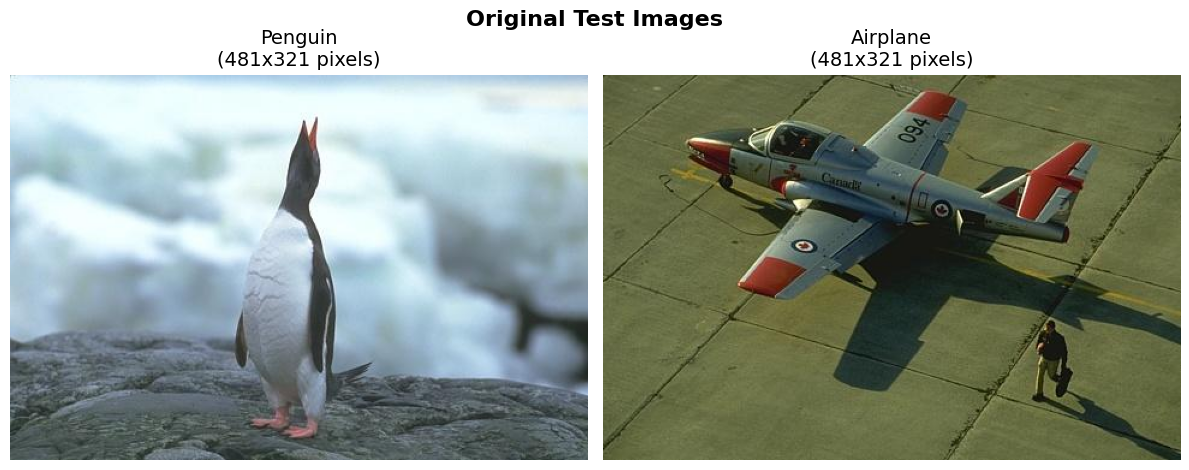


Processing: penguin
Loading image from: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/106024.jpg
Image dimensions: 321 x 481 pixels (154401 total pixels)
Extracting 5D features (row, col, R, G, B)...
Normalizing features to [0, 1]...

Fitting initial GMM with 2 components...

Model selection using 10-fold cross-validation...
Testing model orders from 1 to 5...
Evaluating model order 1...
  Model Order 1: Negative Log-Likelihood = -646917.69
Evaluating model order 2...
  Model Order 2: Negative Log-Likelihood = -776566.88
Evaluating model order 3...
  Model Order 3: Negative Log-Likelihood = -817563.59
Evaluating model order 4...
  Model Order 4: Negative Log-Likelihood = -852796.33
Evaluating model order 5...
  Model Order 5: Negative Log-Likelihood = -893681.46

✓ Best model order: 5

Fitting GMM with best model order 5...

Creating visualizations...


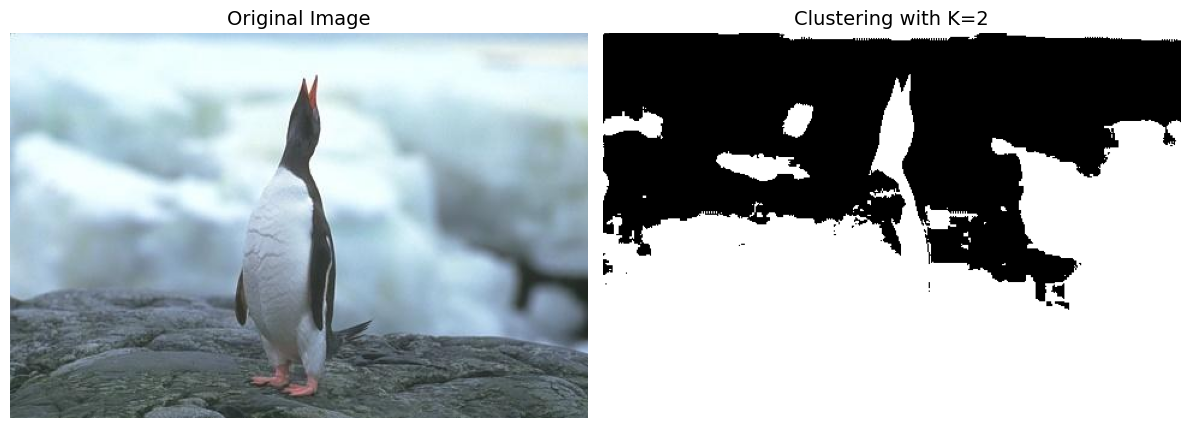

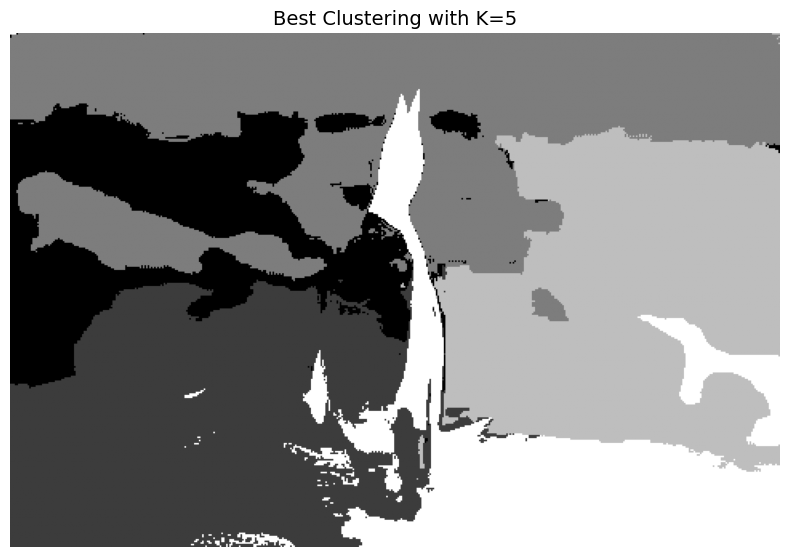

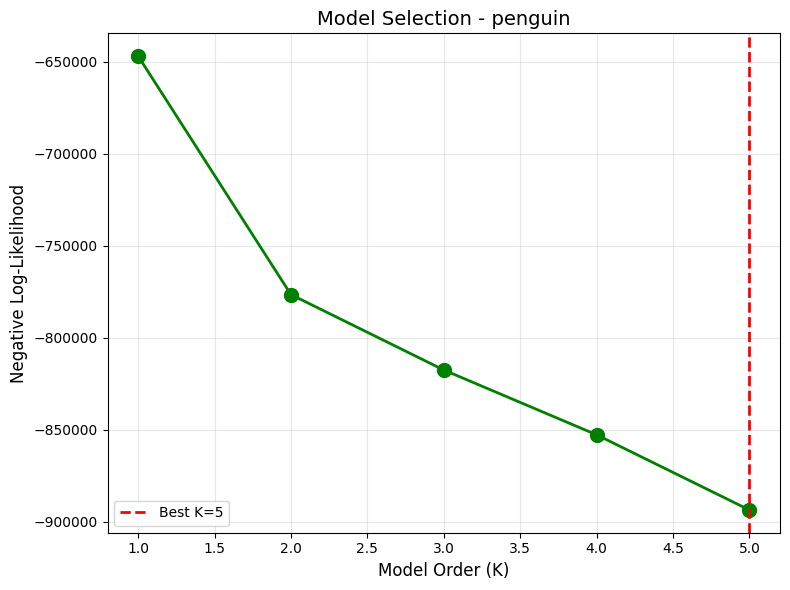


Processing: airplane
Loading image from: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/37073.jpg
Image dimensions: 321 x 481 pixels (154401 total pixels)
Extracting 5D features (row, col, R, G, B)...
Normalizing features to [0, 1]...

Fitting initial GMM with 2 components...

Model selection using 10-fold cross-validation...
Testing model orders from 1 to 5...
Evaluating model order 1...
  Model Order 1: Negative Log-Likelihood = -553056.65
Evaluating model order 2...
  Model Order 2: Negative Log-Likelihood = -942565.89
Evaluating model order 3...
  Model Order 3: Negative Log-Likelihood = -1012689.98
Evaluating model order 4...
  Model Order 4: Negative Log-Likelihood = -1031795.84
Evaluating model order 5...
  Model Order 5: Negative Log-Likelihood = -1076669.52

✓ Best model order: 5

Fitting GMM with best model order 5...

Creating visualizations...


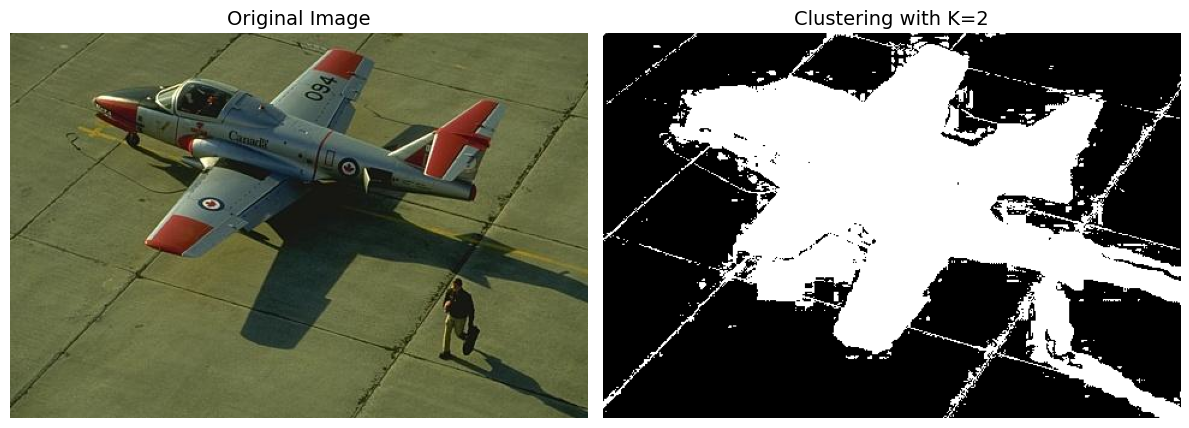

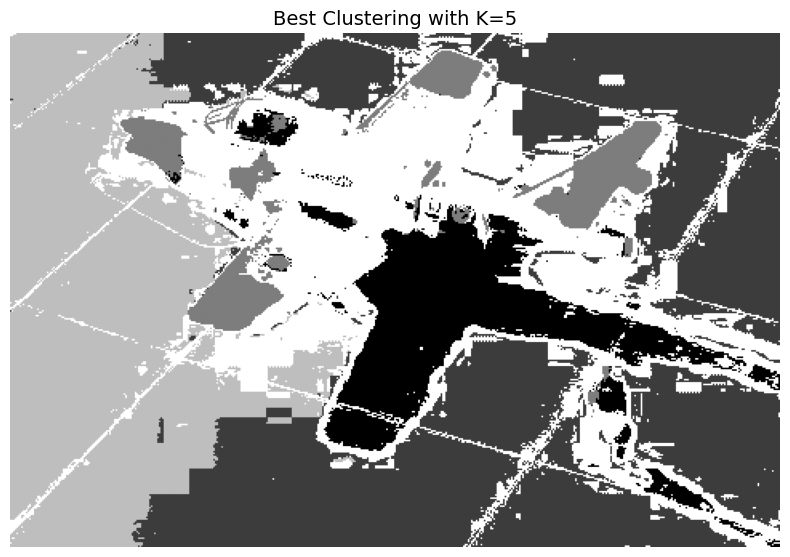

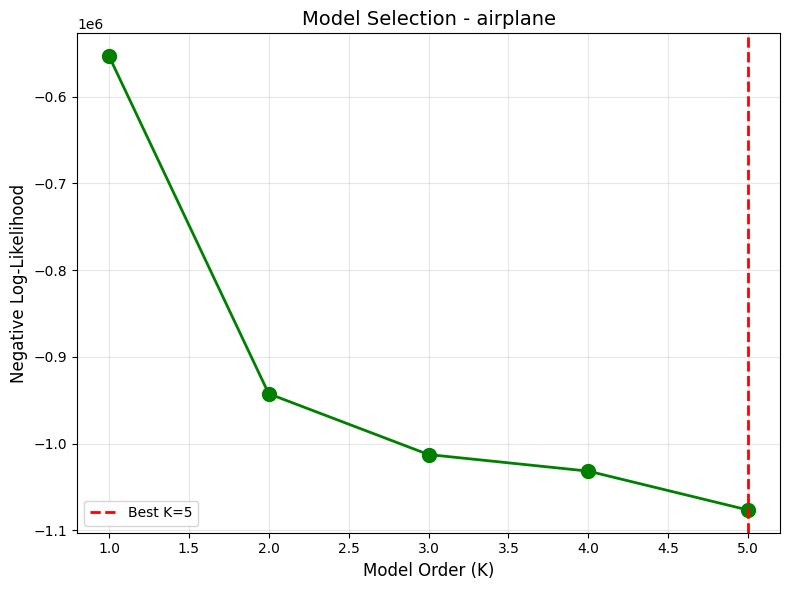

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
import requests
from io import BytesIO

np.random.seed(42)

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def load_image(url):
    """Load image from URL"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB')
    return img

def calc_likelihood(x, model_order, K=10):
    """Calculate negative log-likelihood using K-Fold cross-validation"""
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    negative_log_likelihood = 0.0

    for train_index, val_index in kf.split(x.T):
        X_train, X_val = x[:, train_index], x[:, val_index]
        try:
            gmm = GaussianMixture(n_components=model_order,
                                 covariance_type='full',
                                 random_state=42,
                                 max_iter=100)
            gmm.fit(X_train.T)
            log_likelihood = gmm.score_samples(X_val.T)
            negative_log_likelihood += -np.sum(log_likelihood)
        except Exception as e:
            print(f"An exception occurred: {e}")
            continue

    return negative_log_likelihood

# ============================================================================
# MAIN PROCESSING
# ============================================================================

def process_image(url, image_name, K=10, M=5):
    """Process a single image with GMM segmentation"""

    print(f"\n{'='*70}")
    print(f"Processing: {image_name}")
    print(f"{'='*70}")

    # Load image
    print(f"Loading image from: {url}")
    img = load_image(url)
    imdata = np.array(img)
    R, C, D = imdata.shape
    N = R * C
    imdata = imdata.astype(float)

    print(f"Image dimensions: {R} x {C} pixels ({N} total pixels)")

    # Extract features
    print("Extracting 5D features (row, col, R, G, B)...")
    row_indices = np.repeat(np.arange(R), C)
    col_indices = np.tile(np.arange(C), R)
    red_values = imdata[:, :, 0].flatten()
    green_values = imdata[:, :, 1].flatten()
    blue_values = imdata[:, :, 2].flatten()

    # Stack features: [row, col, R, G, B]
    features = np.vstack((row_indices, col_indices, red_values,
                         green_values, blue_values))

    # Normalize features to [0, 1]
    print("Normalizing features to [0, 1]...")
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features.T).T

    # ========================================================================
    # Initial Clustering with K=2
    # ========================================================================

    initial_model_order = 2
    print(f"\nFitting initial GMM with {initial_model_order} components...")
    gmm_initial = GaussianMixture(n_components=initial_model_order,
                                 covariance_type='full',
                                 random_state=42,
                                 max_iter=100)
    gmm_initial.fit(features_normalized.T)
    labels_initial = gmm_initial.predict(features_normalized.T)
    li_initial = labels_initial.reshape(R, C)

    # ========================================================================
    # Model Selection using Cross-Validation
    # ========================================================================

    print(f"\nModel selection using {K}-fold cross-validation...")
    print(f"Testing model orders from 1 to {M}...")

    ab = []
    for model_order in range(1, M + 1):
        print(f"Evaluating model order {model_order}...")
        neg_log_likelihood = calc_likelihood(features_normalized,
                                             model_order, K=K)
        ab.append(neg_log_likelihood)
        print(f"  Model Order {model_order}: "
              f"Negative Log-Likelihood = {neg_log_likelihood:.2f}")

    ab = np.array(ab)
    best_model_order = np.argmin(ab) + 1
    print(f"\n✓ Best model order: {best_model_order}")

    # ========================================================================
    # Final Clustering with Best Model Order
    # ========================================================================

    print(f"\nFitting GMM with best model order {best_model_order}...")
    gmm_best = GaussianMixture(n_components=best_model_order,
                              covariance_type='full',
                              random_state=42,
                              max_iter=100)
    gmm_best.fit(features_normalized.T)
    labels_best = gmm_best.predict(features_normalized.T)
    li_best = labels_best.reshape(R, C)

    # ========================================================================
    # Visualization
    # ========================================================================

    print("\nCreating visualizations...")

    # Figure 1: Original and K=2 clustering
    # FIXED: Changed filename from 'initial' to 'k2'
    fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))

    # Original image
    axes1[0].imshow(img)
    axes1[0].set_title(f"Original Image", fontsize=14)
    axes1[0].axis('off')

    # K=2 clustering
    li_initial_normalized = (li_initial - li_initial.min()) / \
                           (li_initial.max() - li_initial.min())
    li_initial_visual = (li_initial_normalized * 255).astype(np.uint8)
    axes1[1].imshow(li_initial_visual, cmap='gray')
    axes1[1].set_title(f"Clustering with K={initial_model_order}", fontsize=14)
    axes1[1].axis('off')

    plt.tight_layout()
    plt.savefig(f'q2_{image_name}_k2.png', dpi=150, bbox_inches='tight')  # FIXED FILENAME
    plt.show()

    # Figure 2: Best clustering result
    fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))

    li_best_normalized = (li_best - li_best.min()) / \
                        (li_best.max() - li_best.min())
    li_best_visual = (li_best_normalized * 255 / best_model_order).astype(np.uint8)
    ax2.imshow(li_best_visual, cmap='gray')
    ax2.set_title(f"Best Clustering with K={best_model_order}", fontsize=14)
    ax2.axis('off')

    plt.tight_layout()
    plt.savefig(f'q2_{image_name}_best.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Figure 3: Model selection curve
    fig3, ax3 = plt.subplots(1, 1, figsize=(8, 6))

    ax3.plot(range(1, M + 1), ab, '-go', linewidth=2, markersize=10)
    ax3.axvline(x=best_model_order, color='r', linestyle='--',
                linewidth=2, label=f'Best K={best_model_order}')
    ax3.set_title(f'Model Selection - {image_name}', fontsize=14)
    ax3.set_xlabel('Model Order (K)', fontsize=12)
    ax3.set_ylabel('Negative Log-Likelihood', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    plt.tight_layout()
    plt.savefig(f'q2_{image_name}_selection.png', dpi=150, bbox_inches='tight')
    plt.show()

    return img, best_model_order, ab  # Return img for preview

# ============================================================================
# NEW: GENERATE PREVIEW IMAGE
# ============================================================================

def generate_preview(image_data_list):
    """Generate preview of all selected images"""
    print("\n" + "="*70)
    print("GENERATING PREVIEW IMAGE")
    print("="*70)

    n = len(image_data_list)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))

    if n == 1:
        axes = [axes]

    for i, img_data in enumerate(image_data_list):
        try:
            img = load_image(img_data['url'])
            axes[i].imshow(img)
            axes[i].set_title(f"{img_data['name'].capitalize()}\n({img.size[0]}x{img.size[1]} pixels)",
                            fontsize=14)
            axes[i].axis('off')
            print(f"  - {img_data['name']}: {img.size[0]} x {img.size[1]} pixels")
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Failed to load\n{img_data['name']}",
                        ha='center', va='center', fontsize=12)
            axes[i].axis('off')
            print(f"  - {img_data['name']}: FAILED")

    plt.suptitle('Original Test Images', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('q2_preview.png', dpi=150, bbox_inches='tight')
    print("\n✓ Preview saved as: q2_preview.png")
    plt.show()

# ============================================================================
# PROCESS MULTIPLE IMAGES
# ============================================================================

def main():
    """Main function to process multiple images"""

    # Image URLs from Berkeley Segmentation Dataset
    image_data = [
        {
            'url': "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/106024.jpg",
            'name': 'penguin'
        },
        {
            'url': "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/37073.jpg",
            'name': 'airplane'
        }
    ]

    K = 10  # Number of folds for cross-validation
    M = 5   # Maximum number of model orders to evaluate

    # NEW: Generate preview first
    generate_preview(image_data)

    results = []

    for img_data in image_data:
        try:
            img, best_k, neg_log_likelihoods = process_image(
                img_data['url'],
                img_data['name'],
                K=K,
                M=M
            )
            results.append({
                'name': img_data['name'],
                'best_k': best_k,
                'neg_log_likelihoods': neg_log_likelihoods
            })
        except Exception as e:
            print(f"Error processing {img_data['name']}: {e}")
            continue

# ============================================================================
# RUN MAIN FUNCTION
# ============================================================================

if __name__ == "__main__":
    main()